**IMPORTS**

In [ ]:
%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

**HELPER FUNCTIONS**

In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

**LOAD THE FILES**

In [ ]:
path = "./"
    
filename_train = os.path.join(path,"UNSW_NB15_training-set_csc215.csv") 
filename_test = os.path.join(path,"UNSW_NB15_test-set_csc215.csv")    

df_train = pd.read_csv(filename_train,na_values=['NA','?','-'])
df_test = pd.read_csv(filename_test,na_values=['NA','?','-'])

**PRINT A SAMPLE OF THE DATA**

In [ ]:
print(df_train.head())
print(df_test.head())

print("\nNumber of col/row originally:")
print("Train data: ", df_train.shape)
print("Test data: ",df_test.shape)

   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp     NaN   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp     NaN   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp     NaN   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp     NaN   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0   

**COMBINE TRAIN AND TEST DATA**

In [ ]:
frames = [df_train, df_test]
df = pd.concat(frames)

**CLEANUP THE DATA**

In [ ]:
# Drop the missing values
df = df.dropna()

# Drop the id column
df.drop('id', axis=1, inplace=True)

# Drop the attack_cat column. Not needed, it does not affect the data
df.drop('attack_cat', axis=1, inplace=True)

# Drop the is_sm_ips_ports column. Not significant
df.drop('is_sm_ips_ports', axis=1, inplace=True)

# Remove any existing duplicates rows to avoid biased decisions
df.drop_duplicates(keep='first', inplace=True)


**PRINT A SAMPLE OF THE DATA**

In [ ]:
print(df.head())

print("Number of col/row currently:")
print("Data: ", df.shape)


         dur proto service state  spkts  dpkts  sbytes  dbytes           rate  \
3   1.681642   tcp     ftp   FIN     12     12     628     770      13.677108   
11  2.093085   tcp    smtp   FIN     62     28   56329    2212      42.520967   
15  0.000002   udp    snmp   INT      2      0     138       0  500000.001300   
17  0.393556   tcp    http   FIN     10      8     860    1096      43.195886   
21  0.338017   tcp    http   FIN     10      6     998     268      44.376468   

    sttl  ...  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
3     62  ...           2                 1                 1               3   
11    62  ...           1                 1                 1               2   
15   254  ...           1                 1                 1               4   
17    62  ...           1                 1                 1               2   
21   254  ...           1                 1                 1               1   

    is_ftp_login  ct_ftp_c

**ONE-HOT ENCODE CATEGORICAL VALUES**

In [ ]:
categorical_features = ['proto', 'service', 'state']

for categorical_feature in categorical_features:
  encode_text_dummy(df, categorical_feature)

**NORMALIZE NUMERICAL FEATURES**

In [ ]:
for column in df.columns:
  if column not in categorical_features and column != 'label':
    encode_numeric_zscore(df, column)

**SPLIT THE INPUT AND OUTPUT COLUMNS**

In [ ]:
# Set the label column as output or 'y'
y = df['label']

# Set all column other than label as input or 'x'
x = df.iloc[:,df.columns != 'label']

# Split train and test date 70/30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

**PRINT DATA STATS**

In [ ]:
print("\nNumber of col/row currently:")
print('X Training: ', x_train.shape)
print('Y Training: ', y_train.shape)
print('X Testing: ', x_test.shape)
print('Y Testing: ', y_test.shape)


Number of col/row currently:
X Training:  (42854, 58)
Y Training:  (42854,)
X Testing:  (18367, 58)
Y Testing:  (18367,)


**Logistic Regression**

[[7762  783]
 [ 242 9580]]


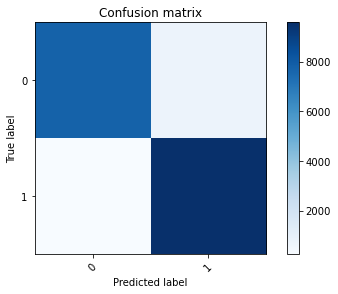

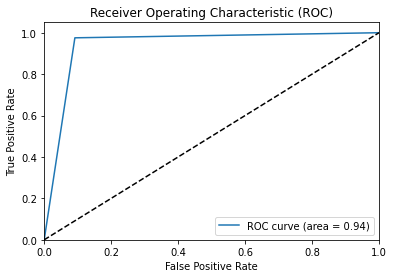

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      8545
           1       0.92      0.98      0.95      9822

    accuracy                           0.94     18367
   macro avg       0.95      0.94      0.94     18367
weighted avg       0.95      0.94      0.94     18367



In [ ]:
# instantiate the model 
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr')

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response
logreg_pred = logreg.predict(x_test)

# Compute the confusion matric
cm = confusion_matrix(y_test, logreg_pred)

# Plot confusion matrics
print(cm)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

# Plot ROC
plot_roc(logreg_pred, y_test)

# Plrint classification report
print(metrics.classification_report(y_test, logreg_pred))

**KNN**

[[8034  511]
 [ 516 9306]]


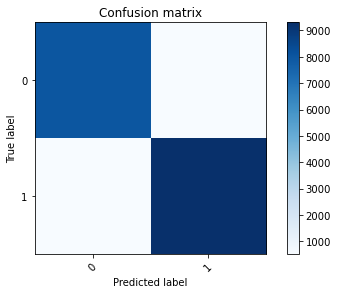

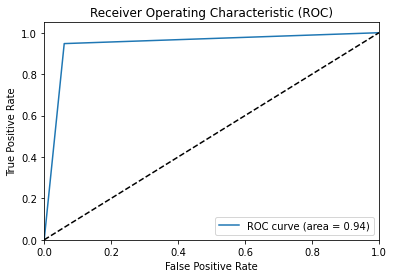

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8545
           1       0.95      0.95      0.95      9822

    accuracy                           0.94     18367
   macro avg       0.94      0.94      0.94     18367
weighted avg       0.94      0.94      0.94     18367



In [ ]:
# instantiate the model (using the value K=1)
knn = KNeighborsClassifier(n_neighbors=1)

# fit the model with data
knn.fit(x_train, y_train)

# predict the response for new observations
knn_pred=knn.predict(x_test)

# Compute the confusion matric
cm = confusion_matrix(y_test, knn_pred)

# Plot confusion matrics
print(cm)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

# Plot ROC
plot_roc(knn_pred, y_test)

# Print classification report
print(metrics.classification_report(y_test, knn_pred))

**SVM**

[[7864  681]
 [ 143 9679]]


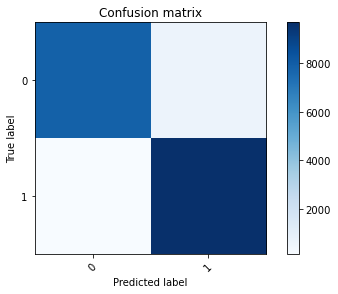

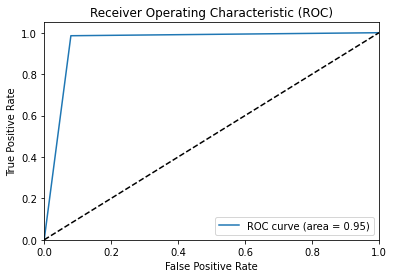

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      8545
           1       0.93      0.99      0.96      9822

    accuracy                           0.96     18367
   macro avg       0.96      0.95      0.95     18367
weighted avg       0.96      0.96      0.96     18367



In [ ]:
svm_clf = SVC(probability=True)
svm_clf.fit(x_train,y_train)
svm_pred=svm_clf.predict(x_test)

# Compute the confusion matric
cm = confusion_matrix(y_test, svm_pred)

# Plot confusion matrics
print(cm)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

# Plot ROC
plot_roc(svm_pred, y_test)

# Print classification report
print(metrics.classification_report(y_test, svm_pred))

***NEURAL NETWORKS***

Fit using relu, adam, binary_crossentropy

In [ ]:
#Convert a Pandas dataframe to the x,y
x,y = to_xy(df,"label")
# Split train and test date 70/30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Optimizer:  adam  Activation Function:  relu
Epoch 1/200
1340/1340 - 3s - loss: 0.1230 - val_loss: 0.1011
Epoch 2/200
1340/1340 - 2s - loss: 0.0949 - val_loss: 0.0957
Epoch 3/200
1340/1340 - 2s - loss: 0.0911 - val_loss: 0.0960
Epoch 4/200
1340/1340 - 2s - loss: 0.0887 - val_loss: 0.0919
Epoch 5/200
1340/1340 - 2s - loss: 0.0873 - val_loss: 0.0872
Epoch 6/200
1340/1340 - 2s - loss: 0.0860 - val_loss: 0.0867
Epoch 7/200
1340/1340 - 2s - loss: 0.0847 - val_loss: 0.0863
Epoch 8/200
1340/1340 - 2s - loss: 0.0839 - val_loss: 0.0911
Epoch 9/200
1340/1340 - 2s - loss: 0.0835 - val_loss: 0.0871
Epoch 10/200
1340/1340 - 2s - loss: 0.0821 - val_loss: 0.0826
Epoch 11/200
1340/1340 - 2s - loss: 0.0815 - val_loss: 0.0836
Epoch 12/200
1340/1340 - 2s - loss: 0.0806 - val_loss: 0.0823
Epoch 13/200
1340/1340 - 3s - loss: 0.0802 - val_loss: 0.0821
Epoch 14/200
1340/1340 - 2s - loss: 0.0791 - val_loss: 0.0838
Epoch 15/200
1340/1340 - 2s - loss: 0.0783 - val_loss: 0.0829
Epoch 00015: early stopping
[[8228

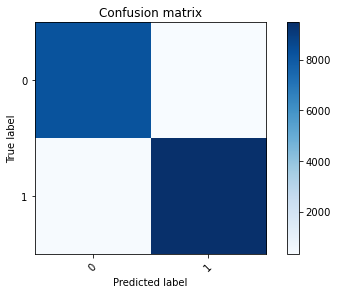

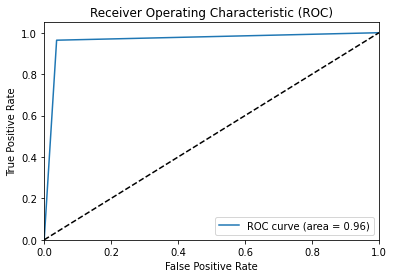

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8545
           1       0.97      0.96      0.97      9822

    accuracy                           0.96     18367
   macro avg       0.96      0.96      0.96     18367
weighted avg       0.96      0.96      0.96     18367




Optimizer:  adam  Activation Function:  sigmoid
Epoch 1/200
1340/1340 - 2s - loss: 0.1721 - val_loss: 0.1238
Epoch 2/200
1340/1340 - 2s - loss: 0.1144 - val_loss: 0.1071
Epoch 3/200
1340/1340 - 2s - loss: 0.1085 - val_loss: 0.1045
Epoch 4/200
1340/1340 - 2s - loss: 0.1040 - val_loss: 0.1074
Epoch 5/200
1340/1340 - 2s - loss: 0.1013 - val_loss: 0.0983
Epoch 6/200
1340/1340 - 2s - loss: 0.0993 - val_loss: 0.0960
Epoch 7/200
1340/1340 - 2s - loss: 0.0974 - val_loss: 0.0986
Epoch 8/200
1340/1340 - 2s - loss: 0.0961 - val_loss: 0.0928
Epoch 9/200
1340/1340 - 2s - loss: 0.0947 - val_loss: 0.0922
Epoch 10/200
1340/1340 - 2s - loss: 0.0933 - val_loss: 0.0924
Epoch 11/20

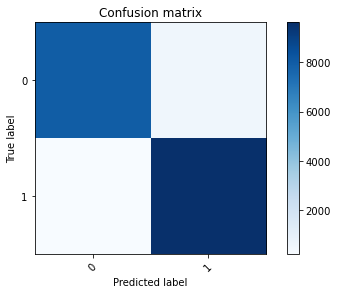

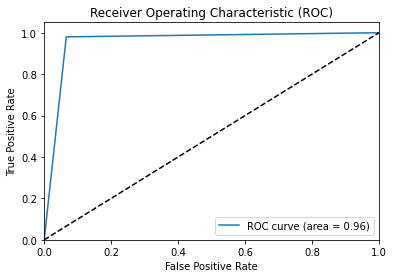

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      8545
           1       0.94      0.98      0.96      9822

    accuracy                           0.96     18367
   macro avg       0.96      0.96      0.96     18367
weighted avg       0.96      0.96      0.96     18367




Optimizer:  adam  Activation Function:  tanh
Epoch 1/200
1340/1340 - 2s - loss: 0.1236 - val_loss: 0.1031
Epoch 2/200
1340/1340 - 2s - loss: 0.0985 - val_loss: 0.0940
Epoch 3/200
1340/1340 - 2s - loss: 0.0927 - val_loss: 0.0966
Epoch 4/200
1340/1340 - 2s - loss: 0.0906 - val_loss: 0.0884
Epoch 5/200
1340/1340 - 2s - loss: 0.0892 - val_loss: 0.0936
Epoch 6/200
1340/1340 - 2s - loss: 0.0869 - val_loss: 0.0860
Epoch 7/200
1340/1340 - 2s - loss: 0.0853 - val_loss: 0.0855
Epoch 8/200
1340/1340 - 2s - loss: 0.0850 - val_loss: 0.0870
Epoch 9/200
1340/1340 - 2s - loss: 0.0842 - val_loss: 0.0867
Epoch 10/200
1340/1340 - 2s - loss: 0.0829 - val_loss: 0.0850
Epoch 11/200
1

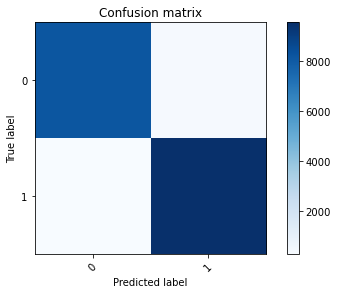

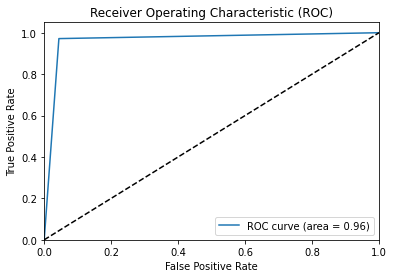

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8545
           1       0.96      0.97      0.97      9822

    accuracy                           0.96     18367
   macro avg       0.96      0.96      0.96     18367
weighted avg       0.96      0.96      0.96     18367




Optimizer:  sgd  Activation Function:  relu
Epoch 1/200
1340/1340 - 2s - loss: 0.2070 - val_loss: 0.1313
Epoch 2/200
1340/1340 - 2s - loss: 0.1186 - val_loss: 0.1120
Epoch 3/200
1340/1340 - 2s - loss: 0.1075 - val_loss: 0.1058
Epoch 4/200
1340/1340 - 2s - loss: 0.1021 - val_loss: 0.1022
Epoch 5/200
1340/1340 - 2s - loss: 0.0992 - val_loss: 0.1006
Epoch 6/200
1340/1340 - 2s - loss: 0.0978 - val_loss: 0.1004
Epoch 7/200
1340/1340 - 2s - loss: 0.0964 - val_loss: 0.0971
Epoch 8/200
1340/1340 - 2s - loss: 0.0951 - val_loss: 0.0963
Epoch 9/200
1340/1340 - 2s - loss: 0.0943 - val_loss: 0.0963
Epoch 10/200
1340/1340 - 2s - loss: 0.0937 - val_loss: 0.0997
Epoch 11/200
13

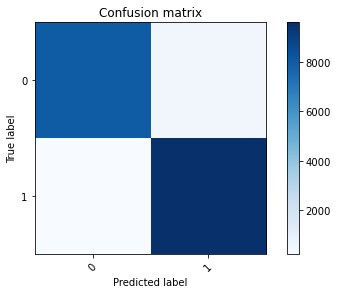

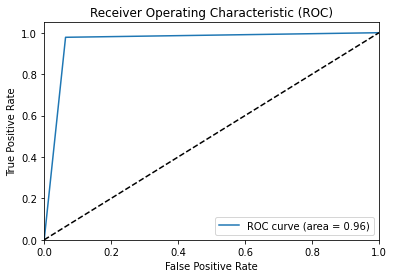

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      8545
           1       0.95      0.98      0.96      9822

    accuracy                           0.96     18367
   macro avg       0.96      0.96      0.96     18367
weighted avg       0.96      0.96      0.96     18367




Optimizer:  sgd  Activation Function:  sigmoid
Epoch 1/200
1340/1340 - 2s - loss: 0.5076 - val_loss: 0.3293
Epoch 2/200
1340/1340 - 2s - loss: 0.2725 - val_loss: 0.2360
Epoch 3/200
1340/1340 - 2s - loss: 0.2152 - val_loss: 0.1958
Epoch 4/200
1340/1340 - 2s - loss: 0.1815 - val_loss: 0.1693
Epoch 5/200
1340/1340 - 2s - loss: 0.1610 - val_loss: 0.1547
Epoch 6/200
1340/1340 - 2s - loss: 0.1493 - val_loss: 0.1482
Epoch 7/200
1340/1340 - 2s - loss: 0.1419 - val_loss: 0.1395
Epoch 8/200
1340/1340 - 2s - loss: 0.1369 - val_loss: 0.1353
Epoch 9/200
1340/1340 - 2s - loss: 0.1330 - val_loss: 0.1354
Epoch 10/200
1340/1340 - 2s - loss: 0.1300 - val_loss: 0.1290
Epoch 11/200

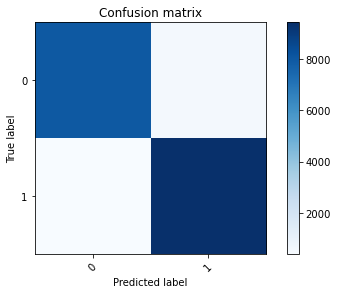

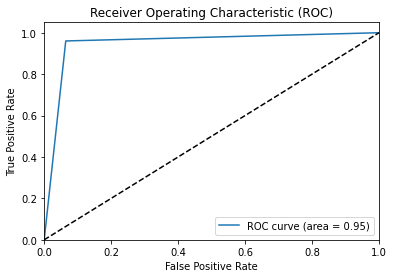

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      8545
           1       0.94      0.96      0.95      9822

    accuracy                           0.95     18367
   macro avg       0.95      0.95      0.95     18367
weighted avg       0.95      0.95      0.95     18367




Optimizer:  sgd  Activation Function:  tanh
Epoch 1/200
1340/1340 - 2s - loss: 0.1820 - val_loss: 0.1316
Epoch 2/200
1340/1340 - 2s - loss: 0.1220 - val_loss: 0.1163
Epoch 3/200
1340/1340 - 2s - loss: 0.1115 - val_loss: 0.1095
Epoch 4/200
1340/1340 - 2s - loss: 0.1068 - val_loss: 0.1055
Epoch 5/200
1340/1340 - 2s - loss: 0.1041 - val_loss: 0.1046
Epoch 6/200
1340/1340 - 2s - loss: 0.1021 - val_loss: 0.1023
Epoch 7/200
1340/1340 - 2s - loss: 0.1009 - val_loss: 0.1023
Epoch 8/200
1340/1340 - 2s - loss: 0.0996 - val_loss: 0.1016
Epoch 9/200
1340/1340 - 2s - loss: 0.0987 - val_loss: 0.1025
Epoch 10/200
1340/1340 - 2s - loss: 0.0981 - val_loss: 0.0990
Epoch 11/200
13

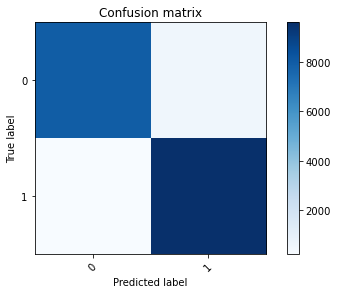

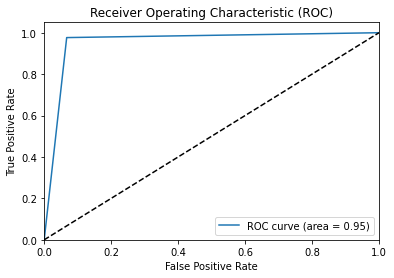

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      8545
           1       0.94      0.98      0.96      9822

    accuracy                           0.96     18367
   macro avg       0.96      0.95      0.96     18367
weighted avg       0.96      0.96      0.96     18367






In [ ]:
# List posible activation functions
activation_functions = ['relu','sigmoid','tanh']
# List posible optimizers
optimizers = ['adam','sgd']

# Loop through all combination of optimizers and activation functions
for optimizer in optimizers:
  for activation_function in activation_functions:
    print("Optimizer: ", optimizer, " Activation Function: ", activation_function)

    model = Sequential()
    model.add(Dense(100, input_dim=x_train.shape[1], activation=activation_function))
    model.add(Dense(50, activation=activation_function))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    #categorical_crossentropy or binary_crossentropy
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    # early stopping
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

    # save best model
    checkpointer = ModelCheckpoint('best_weights.hdf5', verbose=0, save_best_only=True)

    # fit model
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2,epochs=200)

    # load weights from best model
    model.load_weights('best_weights.hdf5')

    pred_nn = model.predict(x_test)

    nn_predicted = np.argmax(pred_nn, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Compute the confusion matric
    cm = confusion_matrix(y_true, nn_predicted)

    # Plot confusion matrics
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Plot ROC
    plot_roc(nn_predicted, y_true)

    # Print classification report
    print(metrics.classification_report(y_true, nn_predicted))

    print("\n\n")